In [2]:
using DSP
using FFTW
using Plots
using Statistics
using StatsBase

# Aim 1: Low Frequency O2 to LFP Relationship

Make a formal description of the relationships between oxygen amperometric signals (<1hz) and local field potentials (LFP) (typically 1-80Hz) recorded simultaneously on separate electrodes.

To do this the O2 will be band-passed between 0.01-1Hz. LFP will be band-passed to 1-45Hz then the envelope will be taken, this will be smoothed using a leaky integrator to oscillate at a similar rate as the O2. 

## Importing Data

In [23]:
include("../helpers/importing.jl")
lfp = import_lfp("Exp 3/R4/2022-05-12_16-46-03/Record Node 101/")
o2 = import_o2("Exp 3/R4/o2lfp r4.txt")

Dict{String, Vector{Float32}} with 4 entries:
  "laser"      => [39824.0, 110812.0, 184330.0, 247107.0, 320937.0, 384378.0, 4…
  "sync"       => [13906.0, 24375.0, 34848.0, 45328.0, 55812.0, 66277.0, 76756.…
  "data"       => [-35.75, -39.797, -34.719, -32.188, -36.406, -35.406, -40.813…
  "timestamps" => [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0  …  961349.…

## Extracting Envelopes of LFP Data

In [24]:
# Compute the Fourier Transform
sampling_rate = 1000
freqs = fftfreq(length(lfp["data"][1,:]), sampling_rate)

# Butterworth's low pass filter equation
function butterworth_low(freq, pass_freq, n=5)
    return 1 / (1 + (abs(freq) / pass_freq) ^ 2n)
end

# Butterworth's high pass filter equation
function butterworth_high(freq, pass_freq, n=5)
    return 1 / (1 + (pass_freq / abs(freq)) ^ 2n)
end


# Apply the Band-Pass Butterworth filter
band = [1, 5]
lfp_envelopes = []
for i in 1:4
    F = fft(lfp["data"][i, :])
    for i in 1:length(F)
        F[i] = F[i] * butterworth_high(freqs[i], band[1]) * butterworth_low(freqs[i], band[2]) 
    end
    banded_lfp = real(ifft(F))
    push!(lfp_envelopes, abs.(hilbert(banded_lfp)))
end
lfp_envelopes

4-element Vector{Any}:
 Float32[0.09309734, 0.092615515, 0.0921267, 0.09163137, 0.09112997, 0.09062265, 0.090110056, 0.0895926, 0.089070566, 0.088544495  …  0.0974711, 0.09707389, 0.09666724, 0.09625128, 0.09582619, 0.09539205, 0.09494942, 0.09449831, 0.09403917, 0.093571976]
 Float32[0.20478366, 0.2055056, 0.20621458, 0.20691068, 0.20759352, 0.20826317, 0.20891945, 0.20956227, 0.21019143, 0.21080703  …  0.19688597, 0.19772911, 0.19856091, 0.19938092, 0.20018919, 0.2009855, 0.20176987, 0.20254199, 0.20330168, 0.20404889]
 Float32[0.13686693, 0.13808209, 0.13929552, 0.14050679, 0.14171578, 0.1429224, 0.14412628, 0.14532731, 0.14652559, 0.14772046  …  0.124646954, 0.12587188, 0.12709635, 0.12832075, 0.12954462, 0.13076767, 0.13199003, 0.13321131, 0.13443129, 0.13564995]
 Float32[0.103807464, 0.104118064, 0.104419, 0.10471026, 0.10499169, 0.10526314, 0.105524525, 0.10577571, 0.10601683, 0.10624756  …  0.10019579, 0.10059642, 0.100988835, 0.10137253, 0.10174749, 0.10211369, 0.102470696, 0.

## Applying a Leaky Integrator to LFP envelopes

In [63]:
include("../helpers/filtering.jl")
lfp_smoothed = leaky_integrator(lfp_envelopes[1]; k=200)

963584-element Vector{Float64}:
 0.0
 4.6548668295145035e-7
 9.285619304863736e-7
 1.3891907741860444e-6
 1.8473406672452731e-6
 2.3029812981957836e-6
 2.7560830262731108e-6
 3.2066195263693587e-6
 3.654566485165018e-6
 4.099901042325364e-6
 ⋮
 0.14788765959973804
 0.14788740553089139
 0.14788714943005163
 0.14788689125070006
 0.14788663094721227
 0.14788636847429934
 0.14788610378954106
 0.14788583685055467
 0.1478855676172301

## Band-Pass Filtering O2 Data

In [49]:
# Compute the Fourier Transform
sampling_rate = 1000
F = fft(o2["data"])
freqs = fftfreq(length(o2["data"]), sampling_rate)

band = [0.01, 1] 
band_pass_F = copy(F)
for i in 1:length(band_pass_F)
    band_pass_F[i] = band_pass_F[i] * butterworth_high(freqs[i], band[1], 5) * butterworth_low(freqs[i], band[2], 5)
end

banded_o2 = real(ifft(band_pass_F))
banded_o2 = standardize(ZScoreTransform, banded_o2)

961359-element Vector{Float32}:
 -2.468245
 -2.4999607
 -2.531674
 -2.5633852
 -2.5950925
 -2.6267972
 -2.658497
 -2.690193
 -2.7218835
 -2.7535677
  ⋮
 -2.182781
 -2.2144957
 -2.246212
 -2.2779298
 -2.3096488
 -2.341368
 -2.3730881
 -2.4048073
 -2.4365265

## Visualising LFP and O2 Relationship

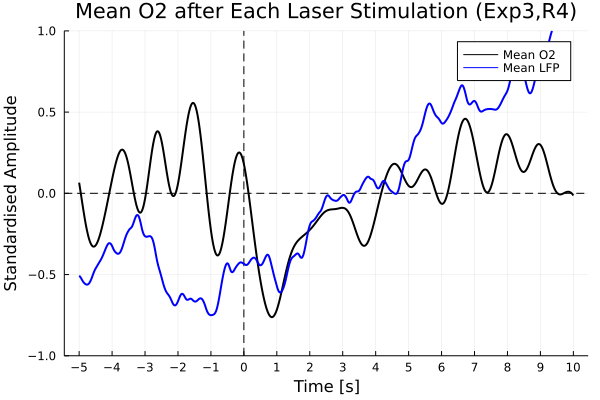

In [64]:
o2_starts = findall(x->x in o2["laser"], o2["timestamps"])
lfp_starts = findall(x->x in lfp["laser"]["on"], lfp["timestamps"])
start = -5000
stop = 10000

vline([0], linestyle=:dash, colour=:grey, label=false, c="Black", ylim=(-1,1))
hline!([0], linestyle=:dash, colour=:grey, label=false, c="Black")

mean_o2 = zeros(length(banded_o2[o2_starts[1]+start:o2_starts[1]+stop]))
mean_lfp = zeros(length(lfp_smoothed[lfp_starts[1]+start:lfp_starts[1]+stop]))

for i in 1:length(o2_starts)
    data = standardize(ZScoreTransform, banded_o2[o2_starts[i]+start:o2_starts[i]+stop])
    mean_o2 += data

    data = standardize(ZScoreTransform, lfp_smoothed[lfp_starts[i]+start:lfp_starts[i]+stop])
    mean_lfp += data
end
mean_o2 ./= length(o2_starts)
mean_lfp ./= length(o2_starts)
plot!((-5:0.001:10), mean_o2, label="Mean O2", c="Black", linewidth=2)  
plot!((-5:0.001:10), mean_lfp, label="Mean LFP", c="Blue", linewidth=2)  

xticks!((-5:10))
title!("Mean O2 after Each Laser Stimulation (Exp3,R4)")
xlabel!("Time [s]")
ylabel!("Standardised Amplitude")

In [65]:
cor(mean_o2, mean_lfp)

0.3538701729026612